In [1]:
# Importing vision-related dependencies from fastai
from fastai.vision.all import *

In [2]:
# Downloading and extracting data
path = untar_data(URLs.MNIST)

In [3]:
# List all the folders in path
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [4]:
# Listing all the file contents in the training folder
(path/'training').ls().sorted()

(#10) [Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/9')]

In [5]:
# Listing all the paths to the images
ones = (path/'training'/'1').ls().sorted()
nines = (path/'training'/'9').ls().sorted()

In [6]:
# Stacking all the images into tensors and normalizing their pixel values
stacked_ones = torch.stack([tensor(Image.open(o)) for o in ones]).float()/255
stacked_nines = torch.stack([tensor(Image.open(o)) for o in nines]).float()/255

<Axes: >

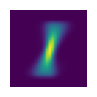

In [7]:
# Finding the ideal 1 and then displaying it
mean1 = stacked_ones.mean(0)
show_image(mean1)

<Axes: >

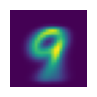

In [8]:
# Finding the ideal 9 and then displaying it
mean9 = stacked_nines.mean(0)
show_image(mean9)

In [9]:
# Creating normalized pixel values for the tensors in the validation dataset
valid_1_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'1').ls()])
valid_1_tens = valid_1_tens.float()/255

In [10]:
valid_9_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'9').ls()])
valid_9_tens = valid_9_tens.float()/255

In [11]:
# Creating the features and the labels
train_x = torch.cat([stacked_ones, stacked_nines]).view(-1, 28*28) # Flattening each image into a row with 784 cols
train_y = tensor([1] * len(ones) + [0] * len(nines)).unsqueeze(1) # Labeling

In [12]:
# Creating the training dataset
dset = list(zip(train_x, train_y))

In [13]:
# Creating the features and labels of the validation dset
valid_x = torch.cat([valid_1_tens, valid_9_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_1_tens) + [0] * len(valid_9_tens)).unsqueeze(1)

In [14]:
# Creating the validation dset
valid_dset = list(zip(valid_x, valid_y))

In [15]:
# Sigmoid function squishes values to between 0 and 1
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# This loss function applies the sigmoid to the model's prediction since binary classification is being done
def mnist_loss(preds, target):
  preds = preds.sigmoid()
  return torch.where(target==1, 1-preds, preds).mean()

In [16]:
# Creating  Dataloaders for both our training dset and validation dset
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [17]:
# Creating a function that calculates the gradient
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [18]:
# This function evaluates the accuracy of our model after each iteration
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds > 0.5) == yb
  return correct.float().mean()

In [19]:
def validate_epoch(model):
  """ This function evaluates the accuracy of the model after each iteration,
     using unseen data from the validation dataset"""
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [20]:
linear_model = nn.Linear(28*28,1) # Linear model that expects 784 inputs and 1 output neuron
w, b = linear_model.parameters() # weights, biases

In [21]:
# Creating a basic optimizer
class BasicOptim:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr # Gradient descent step

  def zero_grad(self, *args, **kwargs):
      for p in self.params:
        p.grad = None

In [22]:
# Creating an instance of our Basic Optimizer
opt = BasicOptim(linear_model.parameters(), lr=1.)

In [23]:
def train_epoch(model):
  """This function trains the model for each epoch, calculates gradient,
    makes the step and then clears the gradient to make sure the model does not learn the wrong signals."""
  for xb, yb in dl:
    calc_grad(xb , yb, model)
    opt.step() # Gradient descent
    opt.zero_grad() # Clears gradients

In [24]:
def train_model(model, epochs):
  """This function trains the model through the whole dataset,
     and then evaluates it using unseen data from the validation dataset."""
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [25]:
# Creating Dataloaders for both the training dset and validation dset
dls = DataLoaders(dl, valid_dl)

In [26]:
"""Creating a simple network with 30 neurons in the hidden layer,
   and one neuron in the output layer with an activation function that enables the model to learn complex patterns"""
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [27]:
# Creating our learner
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [28]:
# Training our model for 40 epochs with a learning rate of 1
learn.fit(40, 1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.166522,0.444971,0.471082,00:00
1,0.058775,0.139341,0.886194,00:00
2,0.025532,0.045728,0.964552,00:00
3,0.013481,0.021806,0.984608,00:00
4,0.008748,0.013809,0.991138,00:00
5,0.006796,0.010420,0.993470,00:00
6,0.005903,0.008631,0.994869,00:00
7,0.005426,0.007576,0.994869,00:00
8,0.005117,0.006884,0.994869,00:00
9,0.004872,0.006409,0.994869,00:00


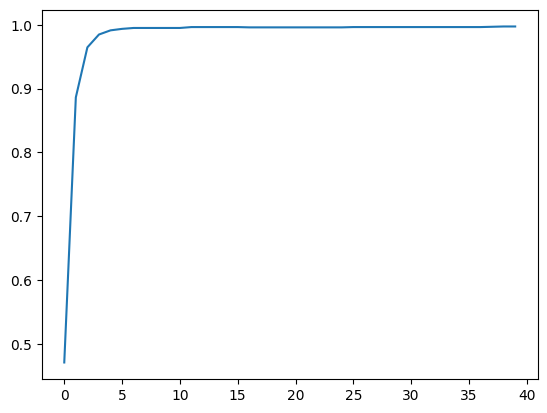

In [29]:
# Plotting the model's accuracy over time
plt.plot(L(learn.recorder.values).itemgot(2))

In [30]:
# Finding the last accuracy value
learn.recorder.values[-1][2]

0.9972015023231506

* Our model is 99% accurate